# Assignment 1: Markov Decision Processes

## Due Date: October 15th (Fri), 11:59 pm.


## Homework Instructions
- All your answers should be written in this notebook. 
- You shouldn't need to write or modify any other files.
- Look for four instances between ``BEGIN YOUR CODE`` and ``END YOUR CODE``--those are the only parts of the code you need to write. To grade your homework, we will check whether the printouts immediately following your code match up with the results we got. The portions used for grading are highlighted in yellow. (However, note that the yellow highlighting does not show up when github renders this file.)

To submit your homework, upload a PDF version of this file (To make the pdf, do `File - Print Preview`)

--------------------------

### Score Breakdown

Question | Points
--- | ---
Question 1 | 6
Question 2 | 4
Question 3a | 6
Question 3b | 4
Total | 20

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

## Introduction

This assignment will review the two classic methods for solving Markov Decision Processes (MDPs) with finite state and action spaces.
We will implement value iteration (VI) and policy iteration (PI) for a finite MDP, both of which find the optimal policy in a finite number of iterations.

The experiments here will use the Frozen Lake environment, a simple gridworld MDP that is taken from `gym` and slightly modified for this assignment. In this MDP, the agent must navigate from the start state to the goal state on a 4x4 grid, with stochastic transitions.

In [1]:
#!pip install gym  # uncomment if you haven't installed the gym library

from frozen_lake import FrozenLakeEnv
env = FrozenLakeEnv()
env.seed(0);
print(env.__doc__)

import numpy as np, numpy.random as nr, gym
np.set_printoptions(precision=3)
def begin_grading(): print("\x1b[43m")
def end_grading(): print("\x1b[0m")


    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.

    


We extract the relevant information from the gym Env into the MDP class below.
The `env` object won't be used any further, we'll just use the `mdp` object.

In [2]:
class MDP(object):
    def __init__(self, P, nS, nA, desc=None):
        self.P = P # state transition and reward probabilities, explained below
        self.nS = nS # number of states
        self.nA = nA # number of actions
        self.desc = desc # 2D array specifying what each grid cell means (used for plotting)
mdp = MDP( {s : {a : [tup[:3] for tup in tups] for (a, tups) in a2d.items()} for (s, a2d) in env.P.items()}, env.nS, env.nA, env.desc)


print("mdp.P is a two-level dict where the first key is the state and the second key is the action.")
print("The 2D grid cells are associated with indices [0, 1, 2, ..., 15] from left to right and top to down, as in")
print(np.arange(16).reshape(4,4))
print("mdp.P[state][action] is a list of tuples (probability, nextstate, reward).\n")
print("For example, state 0 is the initial state, and the transition information for s=0, a=0 is \nP[0][0] =", mdp.P[0][0], "\n")
print("As another example, state 5 corresponds to a hole in the ice, which transitions to itself with probability 1 and reward 0.")
print("P[5][0] =", mdp.P[5][0], '\n')

mdp.P is a two-level dict where the first key is the state and the second key is the action.
The 2D grid cells are associated with indices [0, 1, 2, ..., 15] from left to right and top to down, as in
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
mdp.P[state][action] is a list of tuples (probability, nextstate, reward).

For example, state 0 is the initial state, and the transition information for s=0, a=0 is 
P[0][0] = [(0.1, 0, 0.0), (0.8, 0, 0.0), (0.1, 4, 0.0)] 

As another example, state 5 corresponds to a hole in the ice, which transitions to itself with probability 1 and reward 0.
P[5][0] = [(1.0, 5, 0)] 



<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />


## Part 1: Value Iteration

## Question 1: implement value iteration
In this problem, you'll implement value iteration, which has the following pseudocode:

---
Initialize $V^{(0)}(s)=0$, for all s

For $i=0, 1, 2, \dots$
- $V^{(i+1)}(s) = \max_a \sum_{s'} P(s,a,s') [ R(s,a,s') + \gamma V^{(i)}(s')]$, for all s

---

We additionally define the sequence of greedy policies $\pi^{(0)}, \pi^{(1)}, \dots, \pi^{(n-1)}$, where
$$\pi^{(i)}(s) = \arg \max_a \sum_{s'} P(s,a,s') [ R(s,a,s') + \gamma V^{(i)}(s')]$$

Your code will return two lists: $[V^{(0)}, V^{(1)}, \dots, V^{(n)}]$ and $[\pi^{(0)}, \pi^{(1)}, \dots, \pi^{(n-1)}]$

To ensure that you get the same policies as the reference solution, choose the lower-index action to break ties in $\arg \max_a$. This is done automatically by np.argmax. This will only affect the "# chg actions" printout below--it won't affect the values computed.

<div class="alert alert-warning">
Warning: make a copy of your value function each iteration and use that copy for the update--don't update your value function in place. 
Updating in-place is also a valid algorithm, sometimes called Gauss-Seidel value iteration or asynchronous value iteration, but it will cause you to get different results than me.
</div>

In [3]:
def value_iteration(mdp, gamma, nIt):
    """
    Inputs:
        mdp: MDP
        gamma: discount factor
        nIt: number of iterations, corresponding to n above
    Outputs:
        (value_functions, policies)
        
    len(value_functions) == nIt+1 and len(policies) == n
    """
    print("Iteration | max|V-Vprev| | # chg actions | V[0]")
    print("----------+--------------+---------------+---------")
    Vs = [np.zeros(mdp.nS)] # list of value functions contains the initial value function, which is zero
    pis = []
    for it in range(nIt):
        Vprev = Vs[-1]
        oldpi = pis[-1] if len(pis) > 0 else None

        V = np.zeros(mdp.nS)  # Initialize V
        pi = np.zeros(mdp.nS)  # update states & policy
        
        # BEGIN YOUR CODE
        # -----------------------
        for state in range(mdp.nS):
            s_action=[]
            for a in range(mdp.nA):
                q=[]
                for next_state in range(len(mdp.P[state][a])): 
                    q.append((mdp.P[state][a][next_state][0]*(mdp.P[state][a][next_state][2]+gamma*Vprev[int(mdp.P[state][a][next_state][1])])))      
                s_action.append(sum(q))
            
            V[state]=(max(s_action))  # Value
            
            pi[state]=np.argmax(s_action)  # Policy
        # -----------------------
        # END YOUR CODE
        
        # Your code should define variables V: the bellman backup applied to Vprev
        # and pi: the greedy policy applied to Vprev
        max_diff = np.abs(V - Vprev).max()
        nChgActions="N/A" if oldpi is None else (pi != oldpi).sum()
        print("%4i      | %6.5f      | %4s          | %5.3f"%(it, max_diff, nChgActions, V[0]))
        Vs.append(V)
        pis.append(pi)
    return Vs, pis

GAMMA=0.95 # we'll be using this same value in subsequent problems
begin_grading()
Vs_VI, pis_VI = value_iteration(mdp, gamma=GAMMA, nIt=20)
end_grading()


Iteration | max|V-Vprev| | # chg actions | V[0]
----------+--------------+---------------+---------
   0      | 0.80000      |  N/A          | 0.000
   1      | 0.60800      |    2          | 0.000
   2      | 0.51984      |    2          | 0.000
   3      | 0.39508      |    2          | 0.000
   4      | 0.30026      |    2          | 0.000
   5      | 0.25355      |    1          | 0.254
   6      | 0.10478      |    0          | 0.345
   7      | 0.09657      |    0          | 0.442
   8      | 0.03656      |    0          | 0.478
   9      | 0.02772      |    0          | 0.506
  10      | 0.01111      |    0          | 0.517
  11      | 0.00735      |    0          | 0.524
  12      | 0.00310      |    0          | 0.527
  13      | 0.00190      |    0          | 0.529
  14      | 0.00083      |    0          | 0.530
  15      | 0.00049      |    0          | 0.531
  16      | 0.00022      |    0          | 0.531
  17      | 0.00013      |    0          | 0.531
  18      | 0.000

Below, we've illustrated the progress of value iteration. Your optimal actions are shown by arrows.
At the bottom, the value of the different states are plotted.

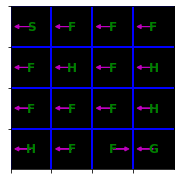

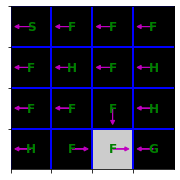

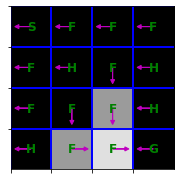

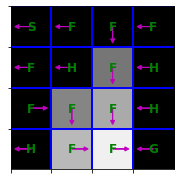

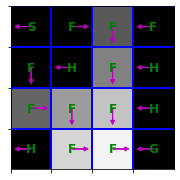

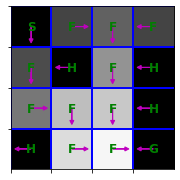

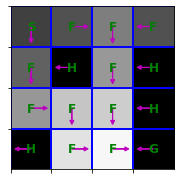

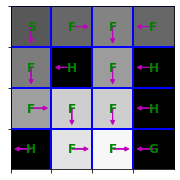

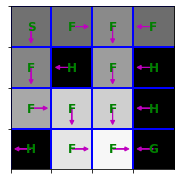

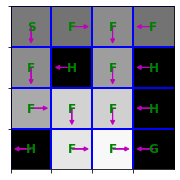

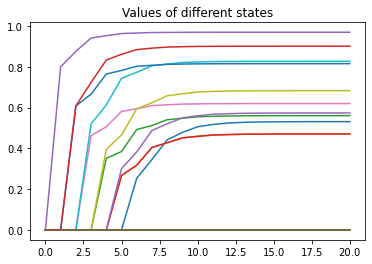

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
for (V, pi) in zip(Vs_VI[:10], pis_VI[:10]):
    plt.figure(figsize=(3,3))
    plt.imshow(V.reshape(4,4), cmap='gray', interpolation='none', clim=(0,1))
    ax = plt.gca()
    ax.set_xticks(np.arange(4)-.5)
    ax.set_yticks(np.arange(4)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {0: (-1, 0), 1:(0, -1), 2:(1,0), 3:(-1, 0)}
    Pi = pi.reshape(4,4)
    for y in range(4):
        for x in range(4):
            a = Pi[y, x]
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.1, head_length=0.1) 
            plt.text(x, y, str(env.desc[y,x].item().decode()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
    plt.grid(color='b', lw=2, ls='-')
plt.figure()
plt.plot(Vs_VI)
plt.title("Values of different states");

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />


## Question 2: construct an MDP where value iteration takes a long time to converge

When we ran value iteration on the frozen lake problem, the last iteration where an action changed was iteration 6--i.e., value iteration computed the optimal policy at iteration 6.
Are there any guarantees regarding how many iterations it'll take value iteration to compute the optimal policy?
There are no such guarantees without additional assumptions--we can construct the MDP in such a way that the greedy policy will change after arbitrarily many iterations.

Your task: define an MDP with at most 3 states and 2 actions, such that when you run value iteration, the optimal action changes at iteration >= 50. Use discount=0.95. (However, note that the discount doesn't matter here--you can construct an appropriate MDP with any discount.)

In [5]:
chg_iter = 50

# BEGIN YOUR CODE
# -----------------------
nS = 3
nA = 2

P = {}
P[0] = {}  # State 0
P[0][0] = []
P[0][0].append((1,1,1))
P[0][1] = []
P[0][1].append((1,0,0))

P[1] = {}  # State 1
P[1][0] = []
P[1][0].append((1,1,0))
P[1][1] = []
P[1][1].append((1,2,-17.5))#This reward affect the optimal action. So when we set the reward under -17.5, optimal action will change after many iterations.

P[2] = {}  # State 2
P[2][0] = []
P[2][0].append((1,2,1))
P[2][1] = []
P[2][1].append((1,0,0))
# -----------------------
# END YOUR CODE

mymdp = MDP(P, nS, nA)

begin_grading()
Vs, pis = value_iteration(mymdp, gamma=GAMMA, nIt=chg_iter+1)
end_grading()


Iteration | max|V-Vprev| | # chg actions | V[0]
----------+--------------+---------------+---------
   0      | 1.00000      |  N/A          | 1.000
   1      | 0.95000      |    0          | 1.000
   2      | 0.90250      |    0          | 1.000
   3      | 0.85737      |    0          | 1.000
   4      | 0.81451      |    0          | 1.000
   5      | 0.77378      |    0          | 1.000
   6      | 0.73509      |    0          | 1.000
   7      | 0.69834      |    0          | 1.000
   8      | 0.66342      |    0          | 1.000
   9      | 0.63025      |    0          | 1.000
  10      | 0.59874      |    0          | 1.000
  11      | 0.56880      |    0          | 1.000
  12      | 0.54036      |    0          | 1.000
  13      | 0.51334      |    0          | 1.000
  14      | 0.48767      |    0          | 1.000
  15      | 0.46329      |    0          | 1.000
  16      | 0.44013      |    0          | 1.000
  17      | 0.41812      |    0          | 1.000
  18      | 0.397

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />


## Question 3: Policy Iteration

The next task is to implement exact policy iteration (PI), which has the following pseudocode:

---
Initialize $\pi_0$

For $n=0, 1, 2, \dots$
1. Compute the state-value function $V^{\pi_{n}}$.
1. Compute the state-action-value function $Q^{\pi_{n}}$ using the state-value function.
1. Compute new policy $\pi_{n+1}(s) = \operatorname*{argmax}_a Q^{\pi_{n}}(s,a)$.
---

Below, you'll implement the first and second steps of the loop.

### Question 3a: state value function

You'll write a function called `compute_vpi` that computes the state-value function $V^{\pi}$ for an arbitrary policy $\pi$.
Recall that $V^{\pi}$ satisfies the following linear equation:
$$V^{\pi}(s) = \sum_{s'} P(s,\pi(s),s')[ R(s,\pi(s),s') + \gamma V^{\pi}(s')]$$
You'll have to solve a linear system in your code.

In [6]:
def compute_vpi(pi, mdp, gamma):
    V = np.zeros(mdp.nS)
    
    # BEGIN YOUR CODE
    # -----------------------
    s_action=[]
    Vs = [np.zeros(mdp.nS)]
    V_prev=Vs[-1]
    
    for state in range(mdp.nS):
        
        q=[]
        for next_state in range(len(mdp.P[state][pi[state]])): 
            q.append((mdp.P[state][pi[state]][next_state][0]*(mdp.P[state][pi[state]][next_state][2]+gamma*V_prev[int(mdp.P[state][pi[state]][next_state][1])])))      

        s_action.append(sum(q))
        V[state]=s_action[state]   
        Vs.append(V) 
    #first iteration(To make V_prev!=V) 
    
    while any(V_prev!=V):
        V=np.zeros(mdp.nS)
        V_prev=Vs[-1]
        s_action=[]
        for state in range(mdp.nS):
            q=[]
            for next_state in range(len(mdp.P[state][pi[state]])): 
                q.append((mdp.P[state][pi[state]][next_state][0]*(mdp.P[state][pi[state]][next_state][2]+gamma*V_prev[int(mdp.P[state][pi[state]][next_state][1])])))      
            s_action.append(sum(q))
            V[state]=s_action[state]

        Vs.append(V)

    # -----------------------
    # END YOUR CODE
            
    return V

Now let's compute the value of an arbitrarily-chosen policy. 


In [7]:
begin_grading()
print(compute_vpi(np.ones(16), mdp, gamma=GAMMA))
end_grading()


[0.016 0.024 0.232 0.024 0.017 0.    0.299 0.    0.02  0.188 0.393 0.
 0.    0.196 0.494 0.   ]



As a sanity check, if we run `compute_vpi` on the solution from our previous value iteration run, we should get approximately (but not exactly) the same values produced by value iteration.

In [8]:
Vpi=compute_vpi(pis_VI[15], mdp, gamma=GAMMA)
V_vi = Vs_VI[15]
print("From compute_vpi", Vpi)
print("From value iteration", V_vi)
print("Difference", Vpi - V_vi)

From compute_vpi [0.531 0.471 0.56  0.471 0.574 0.    0.62  0.    0.683 0.827 0.815 0.
 0.    0.901 0.97  0.   ]
From value iteration [0.53  0.47  0.56  0.47  0.573 0.    0.62  0.    0.683 0.827 0.815 0.
 0.    0.901 0.97  0.   ]
Difference [9.580e-04 3.839e-04 2.254e-04 3.839e-04 4.495e-04 0.000e+00 4.522e-05
 0.000e+00 2.612e-04 1.071e-04 3.272e-05 0.000e+00 0.000e+00 3.977e-05
 7.051e-06 0.000e+00]


### Question 3b: state-action value function

Next, you'll write a function to compute the state-action value function $Q^{\pi}$, defined as follows

$$Q^{\pi}(s, a) = \sum_{s'} P(s,a,s')[ R(s,a,s') + \gamma V^{\pi}(s')]$$


In [9]:
def compute_qpi(vpi, pi, mdp,  gamma):
    Qpi = np.zeros([mdp.nS,mdp.nA])
    
    # BEGIN YOUR CODE
    # -----------------------
    for state in range(mdp.nS):
        s_action=[]
        for a in range(mdp.nA):
            q=[]
            for next_state in range(len(mdp.P[state][a])): 
                q.append((mdp.P[state][a][next_state][0]*(mdp.P[state][a][next_state][2]+gamma*vpi[int(mdp.P[state][a][next_state][1])])))      
            s_action.append(sum(q))
            Qpi[state,a]=s_action[-1]

    # -----------------------
    # END YOUR CODE
    
    return Qpi

begin_grading()
Qpi = compute_qpi(Vpi, pis_VI[-1], mdp, gamma=0.95)
end_grading()
print("Qpi:\n", Qpi)



Qpi:
 [[0.509 0.531 0.463 0.499]
 [0.448 0.104 0.471 0.461]
 [0.47  0.56  0.47  0.515]
 [0.471 0.098 0.402 0.456]
 [0.551 0.574 0.115 0.458]
 [0.    0.    0.    0.   ]
 [0.131 0.62  0.131 0.426]
 [0.    0.    0.    0.   ]
 [0.574 0.143 0.683 0.579]
 [0.605 0.827 0.705 0.142]
 [0.78  0.815 0.151 0.55 ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.164 0.777 0.901 0.721]
 [0.854 0.922 0.97  0.805]
 [0.    0.    0.    0.   ]]


Now we're ready to run policy iteration!

Iteration | # chg actions | V[0]
----------+---------------+---------
   0      |      1        | 0.00000
   1      |      6        | 0.00000
   2      |      3        | 0.00000
   3      |      1        | 0.44131
   4      |      1        | 0.45546
   5      |      0        | 0.53118
   6      |      0        | 0.53118
   7      |      0        | 0.53118
   8      |      0        | 0.53118
   9      |      0        | 0.53118
  10      |      0        | 0.53118
  11      |      0        | 0.53118
  12      |      0        | 0.53118
  13      |      0        | 0.53118
  14      |      0        | 0.53118
  15      |      0        | 0.53118
  16      |      0        | 0.53118
  17      |      0        | 0.53118
  18      |      0        | 0.53118
  19      |      0        | 0.53118


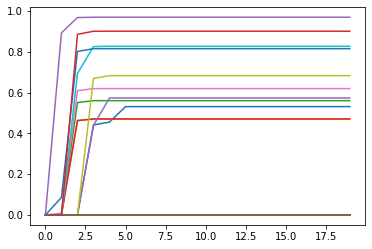

In [10]:
def policy_iteration(mdp, gamma, nIt):
    Vs = []
    pis = []
    pi_prev = np.zeros(mdp.nS,dtype='int')
    pis.append(pi_prev)
    print("Iteration | # chg actions | V[0]")
    print("----------+---------------+---------")
    for it in range(nIt):        
        vpi = compute_vpi(pi_prev, mdp, gamma)
        qpi = compute_qpi(vpi, pi_prev, mdp, gamma)
        pi = qpi.argmax(axis=1)
        print("%4i      | %6i        | %6.5f"%(it, (pi != pi_prev).sum(), vpi[0]))
        Vs.append(vpi)
        pis.append(pi)
        pi_prev = pi
    return Vs, pis
Vs_PI, pis_PI = policy_iteration(mdp, gamma=0.95, nIt=20)
plt.plot(Vs_PI);

Now we can compare the convergence of value iteration and policy iteration on several states.
For fun, you can try adding modified policy iteration.

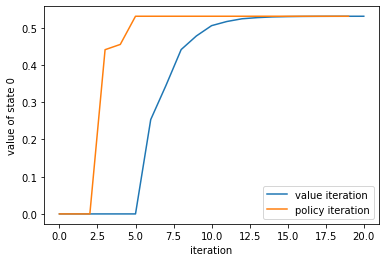

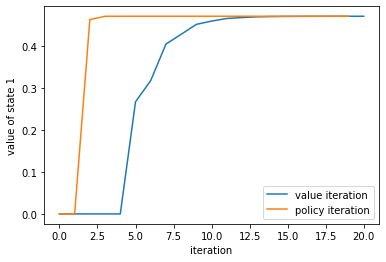

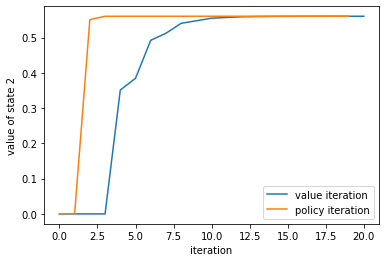

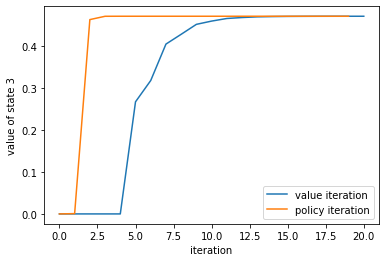

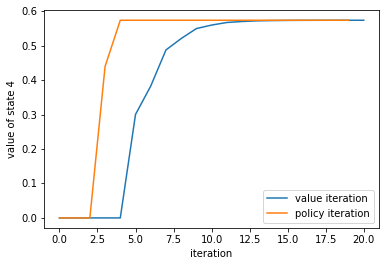

In [11]:
for s in range(5):
    plt.figure()
    plt.plot(np.array(Vs_VI)[:,s])
    plt.plot(np.array(Vs_PI)[:,s])
    plt.ylabel("value of state %i"%s)
    plt.xlabel("iteration")
    plt.legend(["value iteration", "policy iteration"], loc='best')

### Congratulations! You have completed HW1.

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output.

Please generate pdf as follows and submit it to Gradescope.

**File > Print Preview > Print > Save as pdf**

**Please save before submitting!**